## DoSを分析するノートブック

In [193]:
using Plots
using DataFrames
using CSV
using StatsBase
using JLD2
using FileIO

### 出力結果の読み込みと設定

In [276]:
df = load("output.jld2")["results"]
M = length( names(df) ) - 4
num_states = 2^M
n = size(df[df.β.==1.0, :])[1]
B = unique(df.β)
T = length(B)
num_bins = 100
num_states

2097152

## マルチヒストグラム法によるDoSの推定

In [277]:
all_neg_log_likelihood = vec(Float64.(df.E))
hist = fit(Histogram, all_neg_log_likelihood, nbins=num_bins)

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -145.0:5.0:215.0
weights: [12102, 4258, 352, 2946, 1017, 2165, 3331, 434, 3018, 1395  …  0, 1, 0, 1, 1, 0, 0, 0, 1, 1]
closed: left
isdensity: false

In [278]:
edges = Vector(hist.edges[1])
E = (edges[1:end-1] + edges[2:end]) ./ 2.0
H = hist.weights
tolerance = 1e-10
max_iter = 1000

Z = ones(T)
D = ones(length(H))
for i in 1:max_iter
    prev_Z = deepcopy(Z)

    D = vec( H ./ ( exp.( - E*B' ) * ( n ./ Z ) ) )
    Z = vec( D' * exp.( - E*B' ) )
    
    err = mean(abs.(Z .- prev_Z))
    if err < tolerance
        println("i=$i, err=$err")
        break
    end
end


i=229, err=2.739082684461358e-48


### DoSの描画

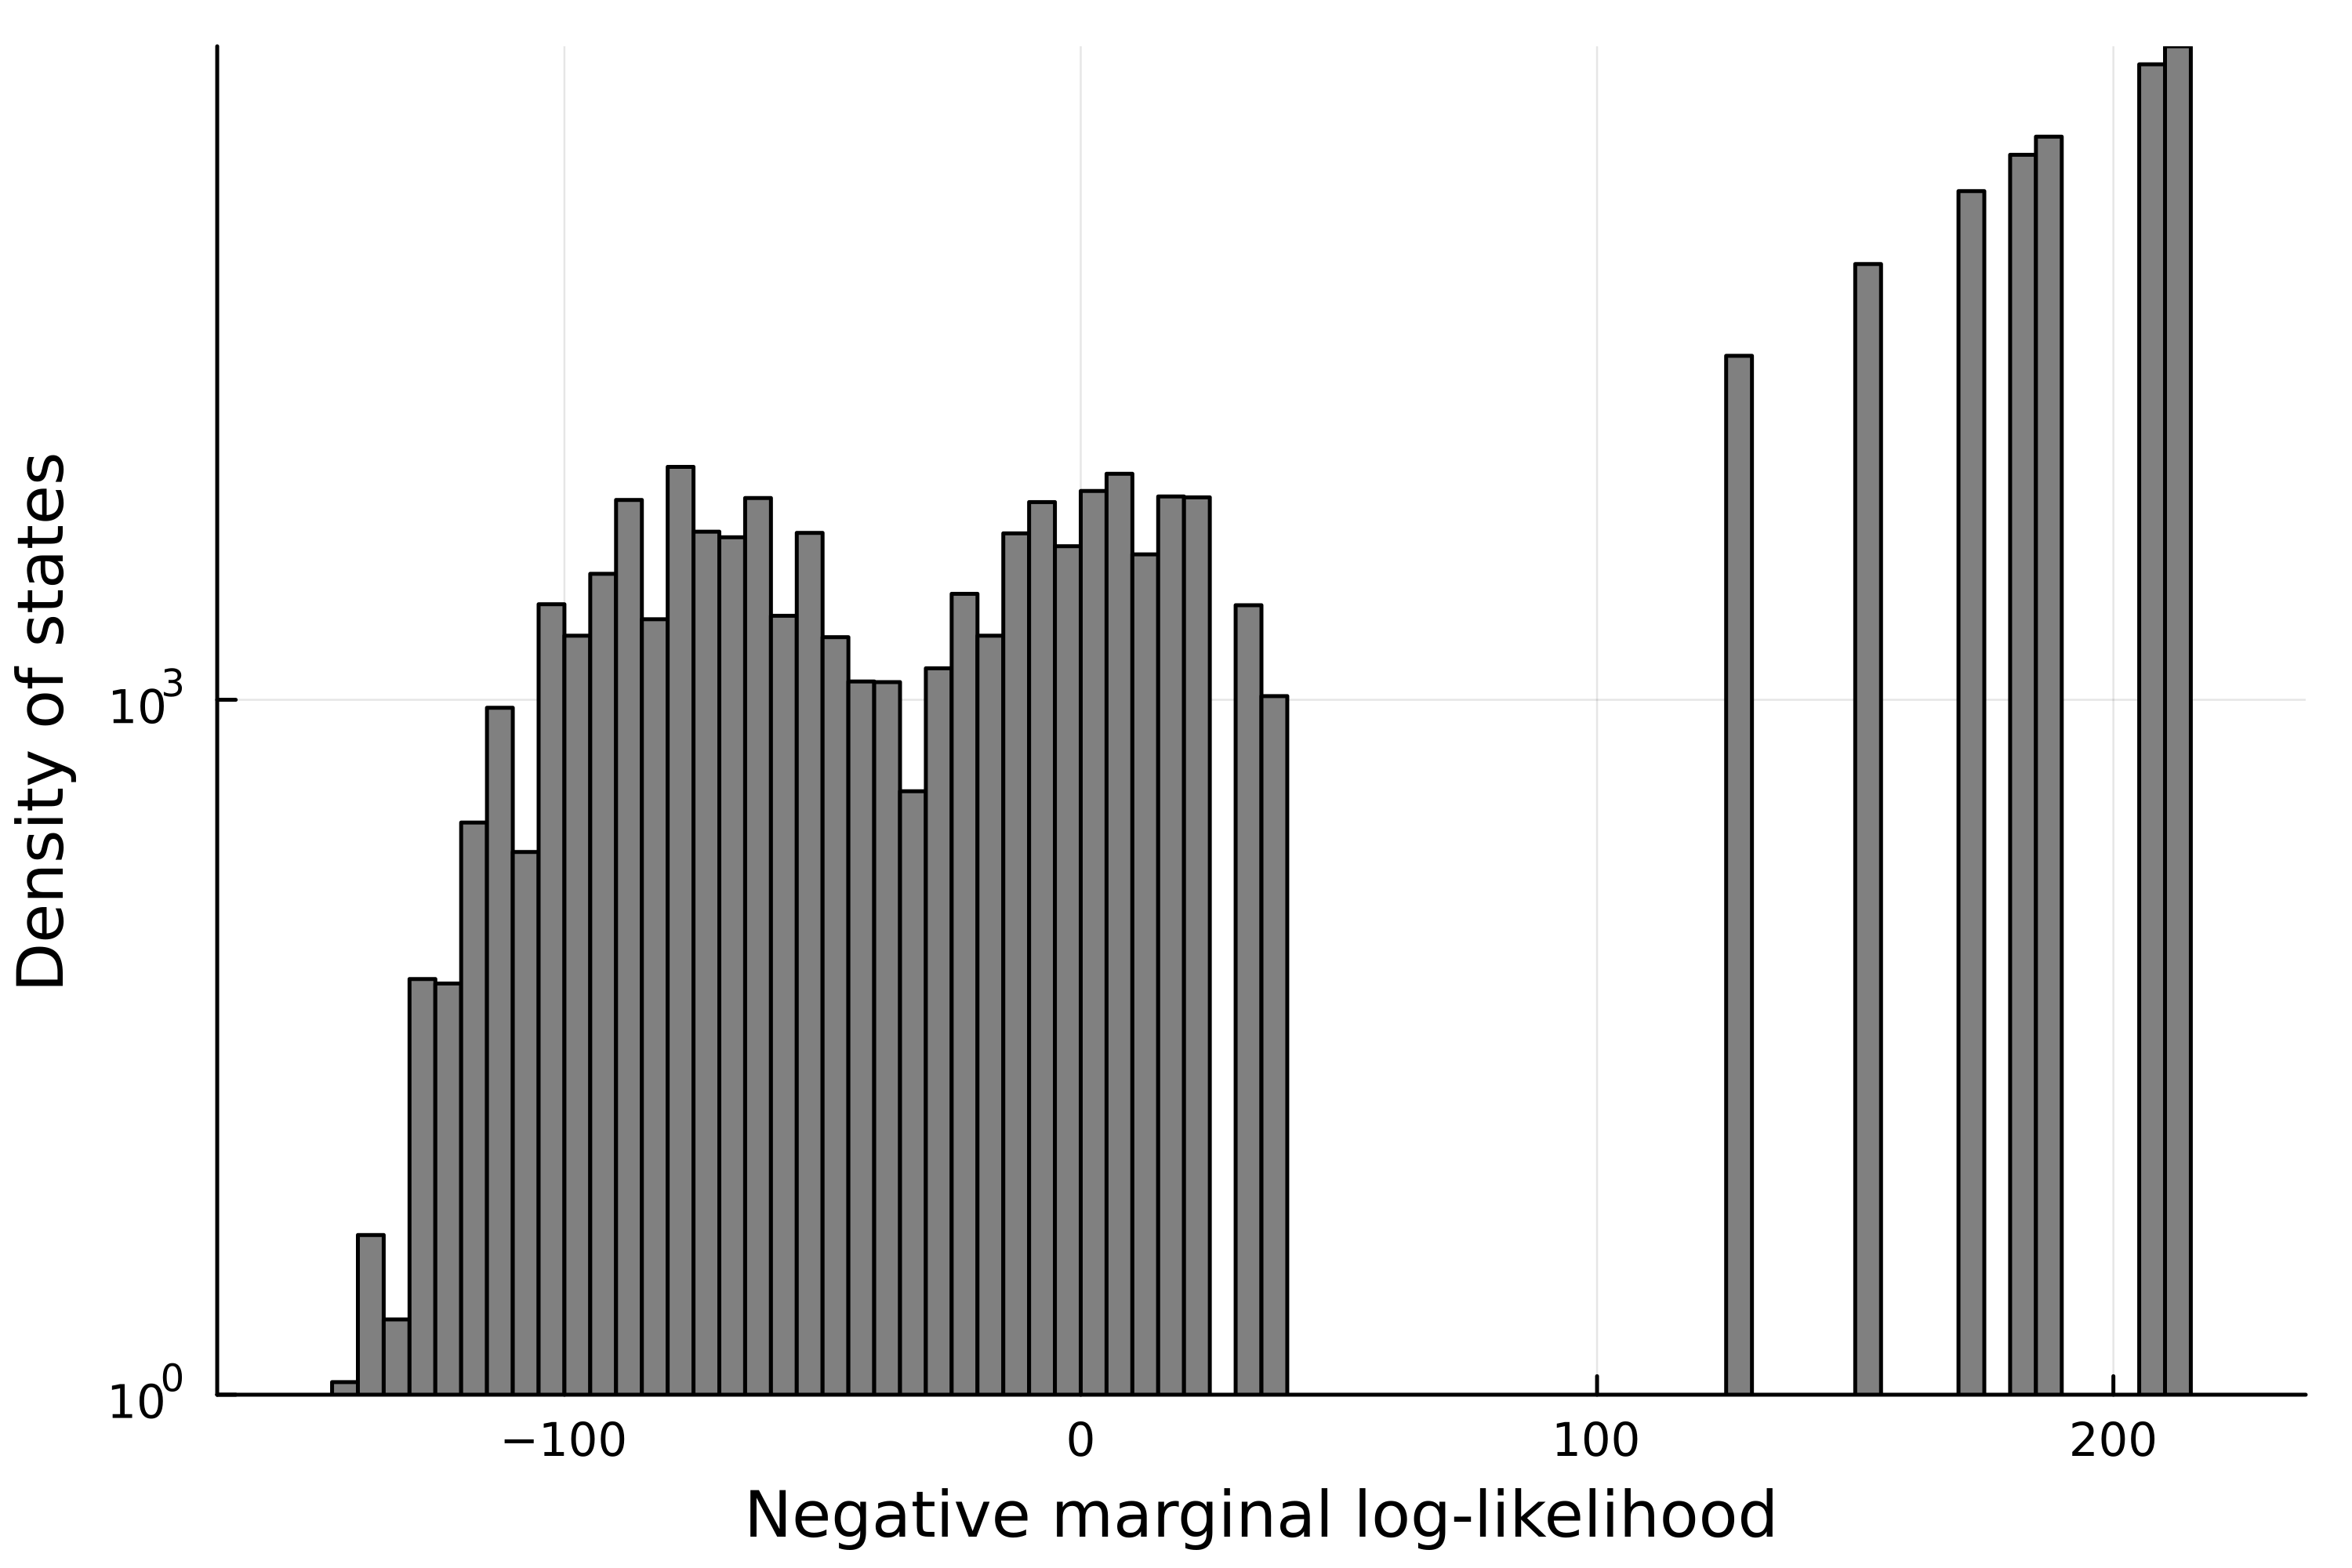

In [279]:
width = abs(E[1] - E[2])
plt = bar( E[D.!=0],  num_states .*( D[D.!=0] / sum(D[D.!=0]) ), legend=false,
xlabel="Negative marginal log-likelihood", ylabel = "Density of states",yscale=:log10, 
dpi=500, color="gray",  bar_width=width)

### DoSのサブセットの導出

In [280]:
pattern = r"110.................."
df_selected = df[occursin.(pattern, df.P), :]

histₛ = fit(Histogram, vec(Float64.(df_selected.E)), hist.edges[1])
Eₛ = (Vector(histₛ.edges[1])[1:end-1] + Vector(histₛ.edges[1])[2:end]) ./ 2.0
Hₛ = histₛ.weights
Dₛ = vec( Hₛ ./ ( exp.( - Eₛ*B' ) * ( n ./ Z ) ) )

( num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ) )'

1×2 adjoint(::Vector{Float64}) with eltype Float64:
 30542.7  76050.8

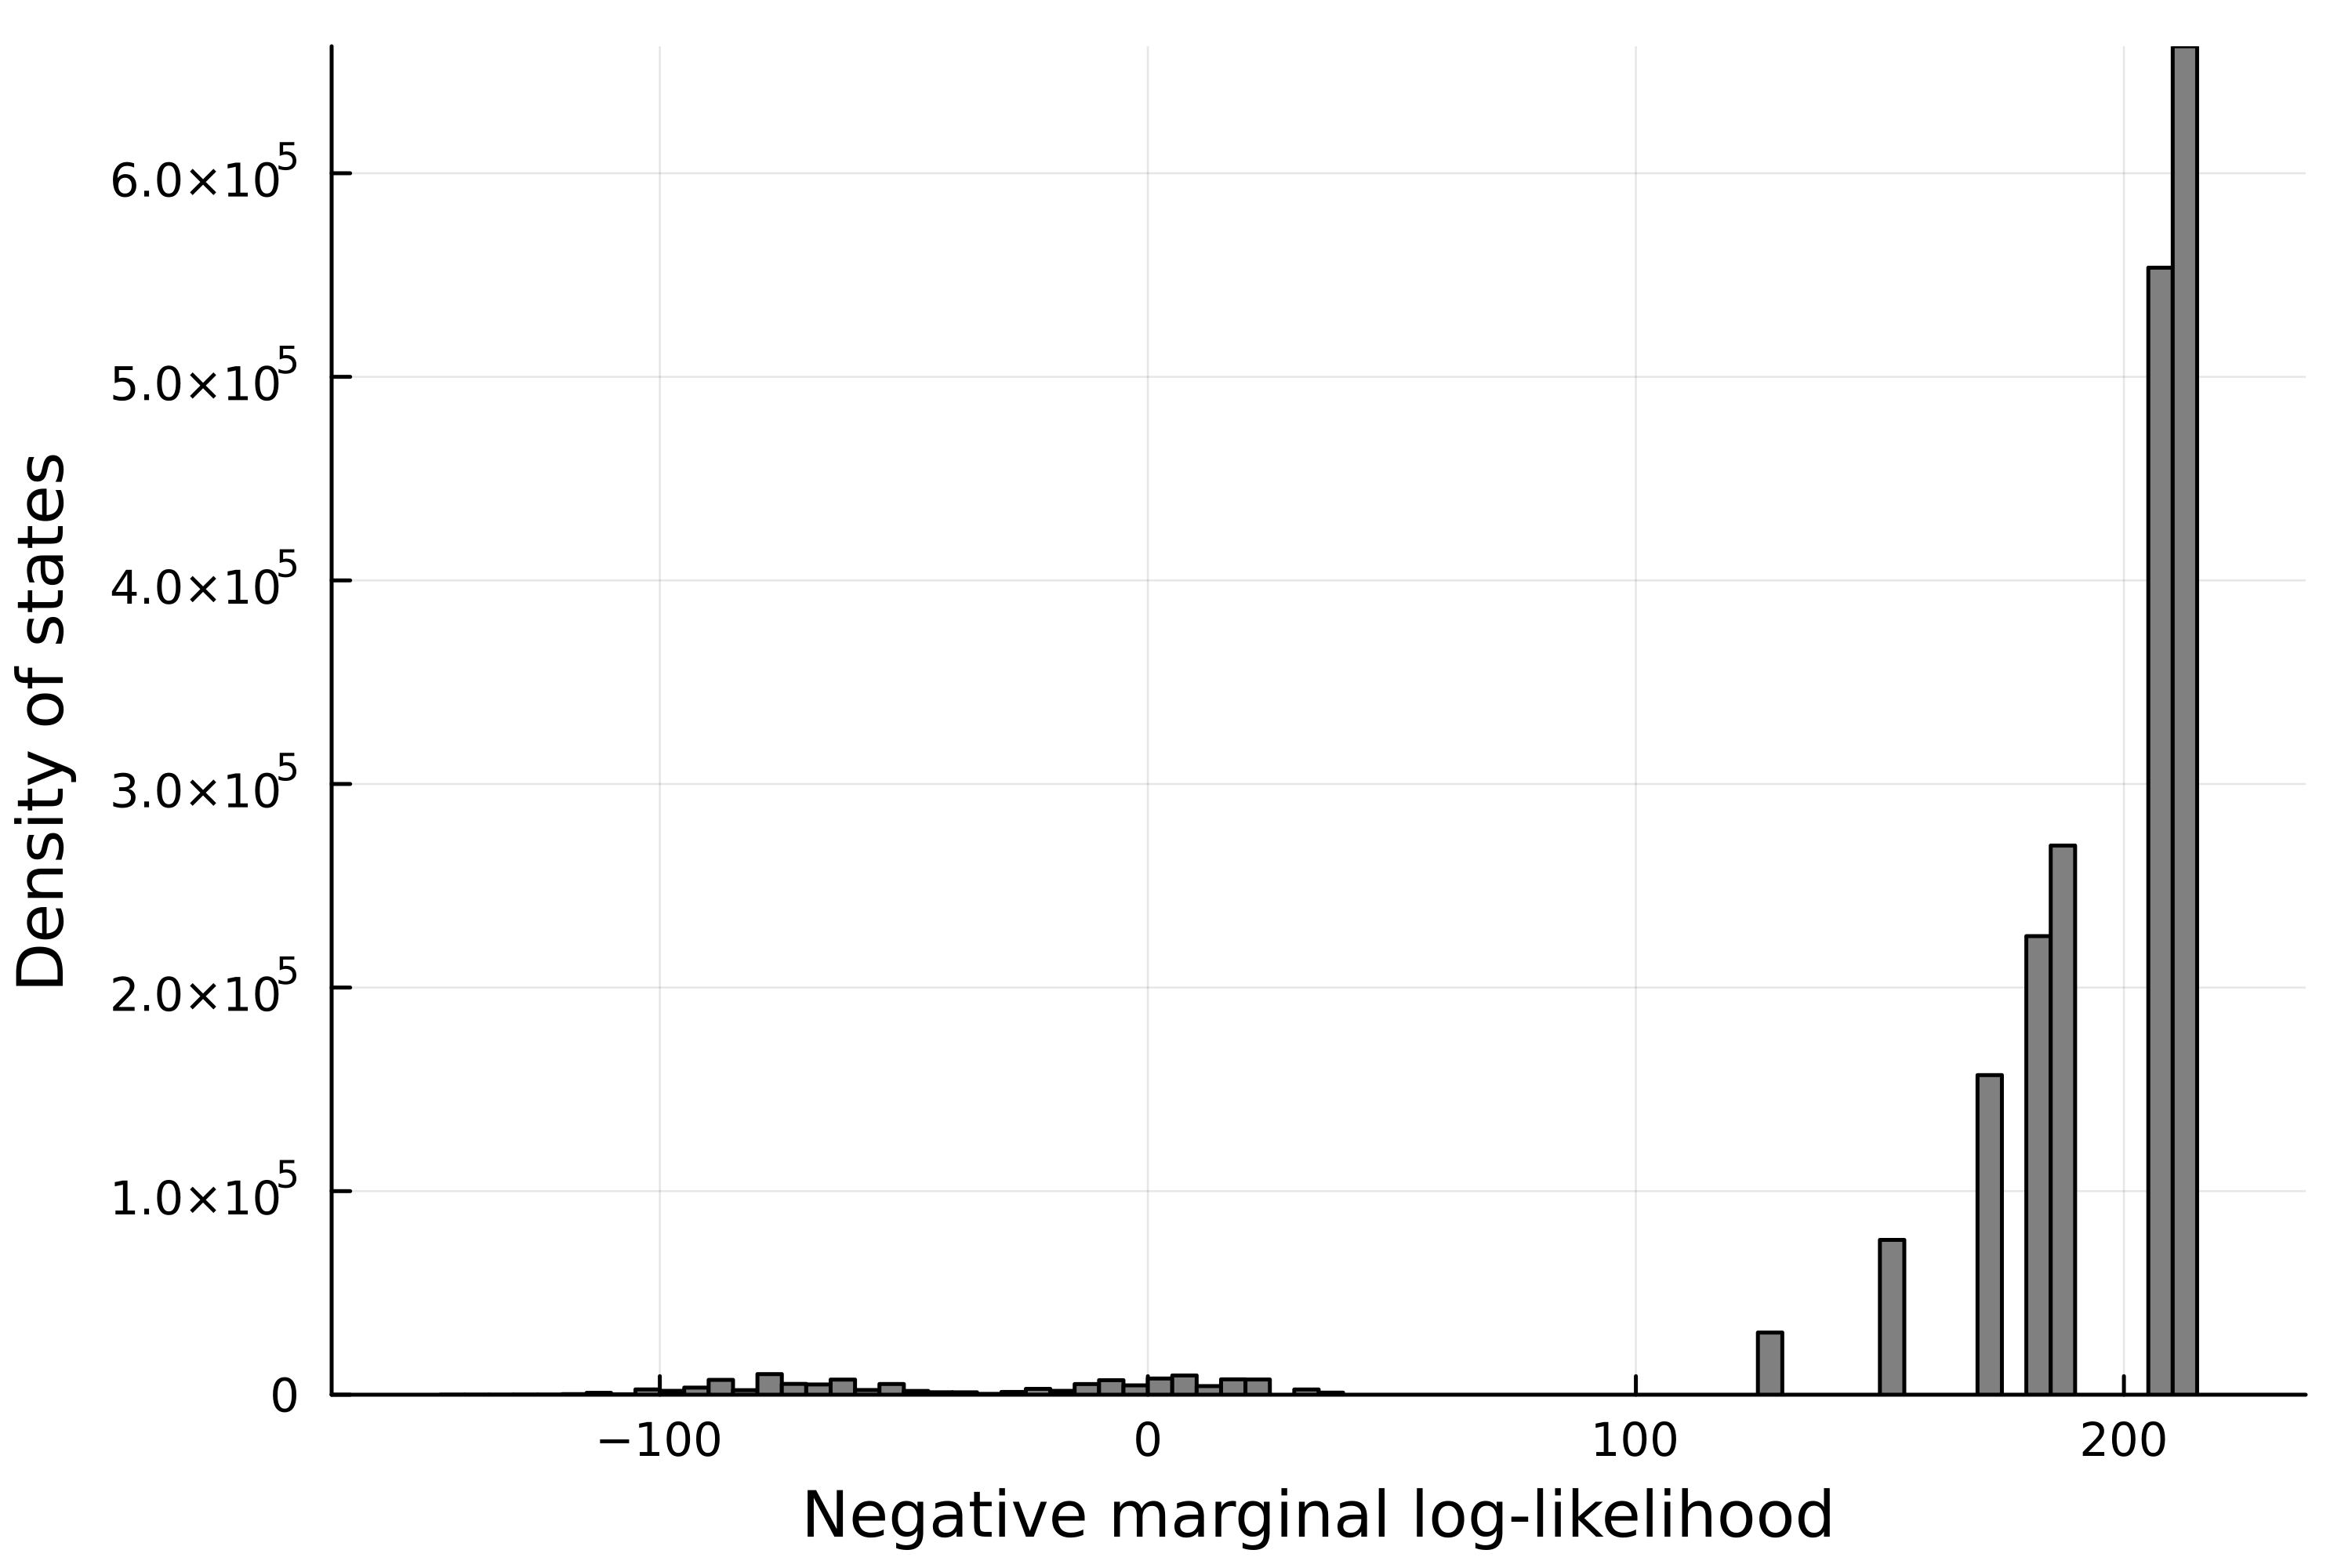

In [281]:
plot()
plt = bar( E[D.!=0],  num_states .*( D[D.!=0] / sum(D[D.!=0]) ), legend=false,
xlabel="Negative marginal log-likelihood", ylabel = "Density of states",#yscale=:log10, 
dpi=500, color="gray",  bar_width=width, label="")

# plt = bar!( Eₛ[Dₛ.!=0], num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ), legend=true,
# xlabel="Negative marginal log-likelihood", ylabel = "Density of states",# yscale=:log10,
# dpi=500, color="blue",  bar_width=width, label=pattern)

### DoSのクラス分け

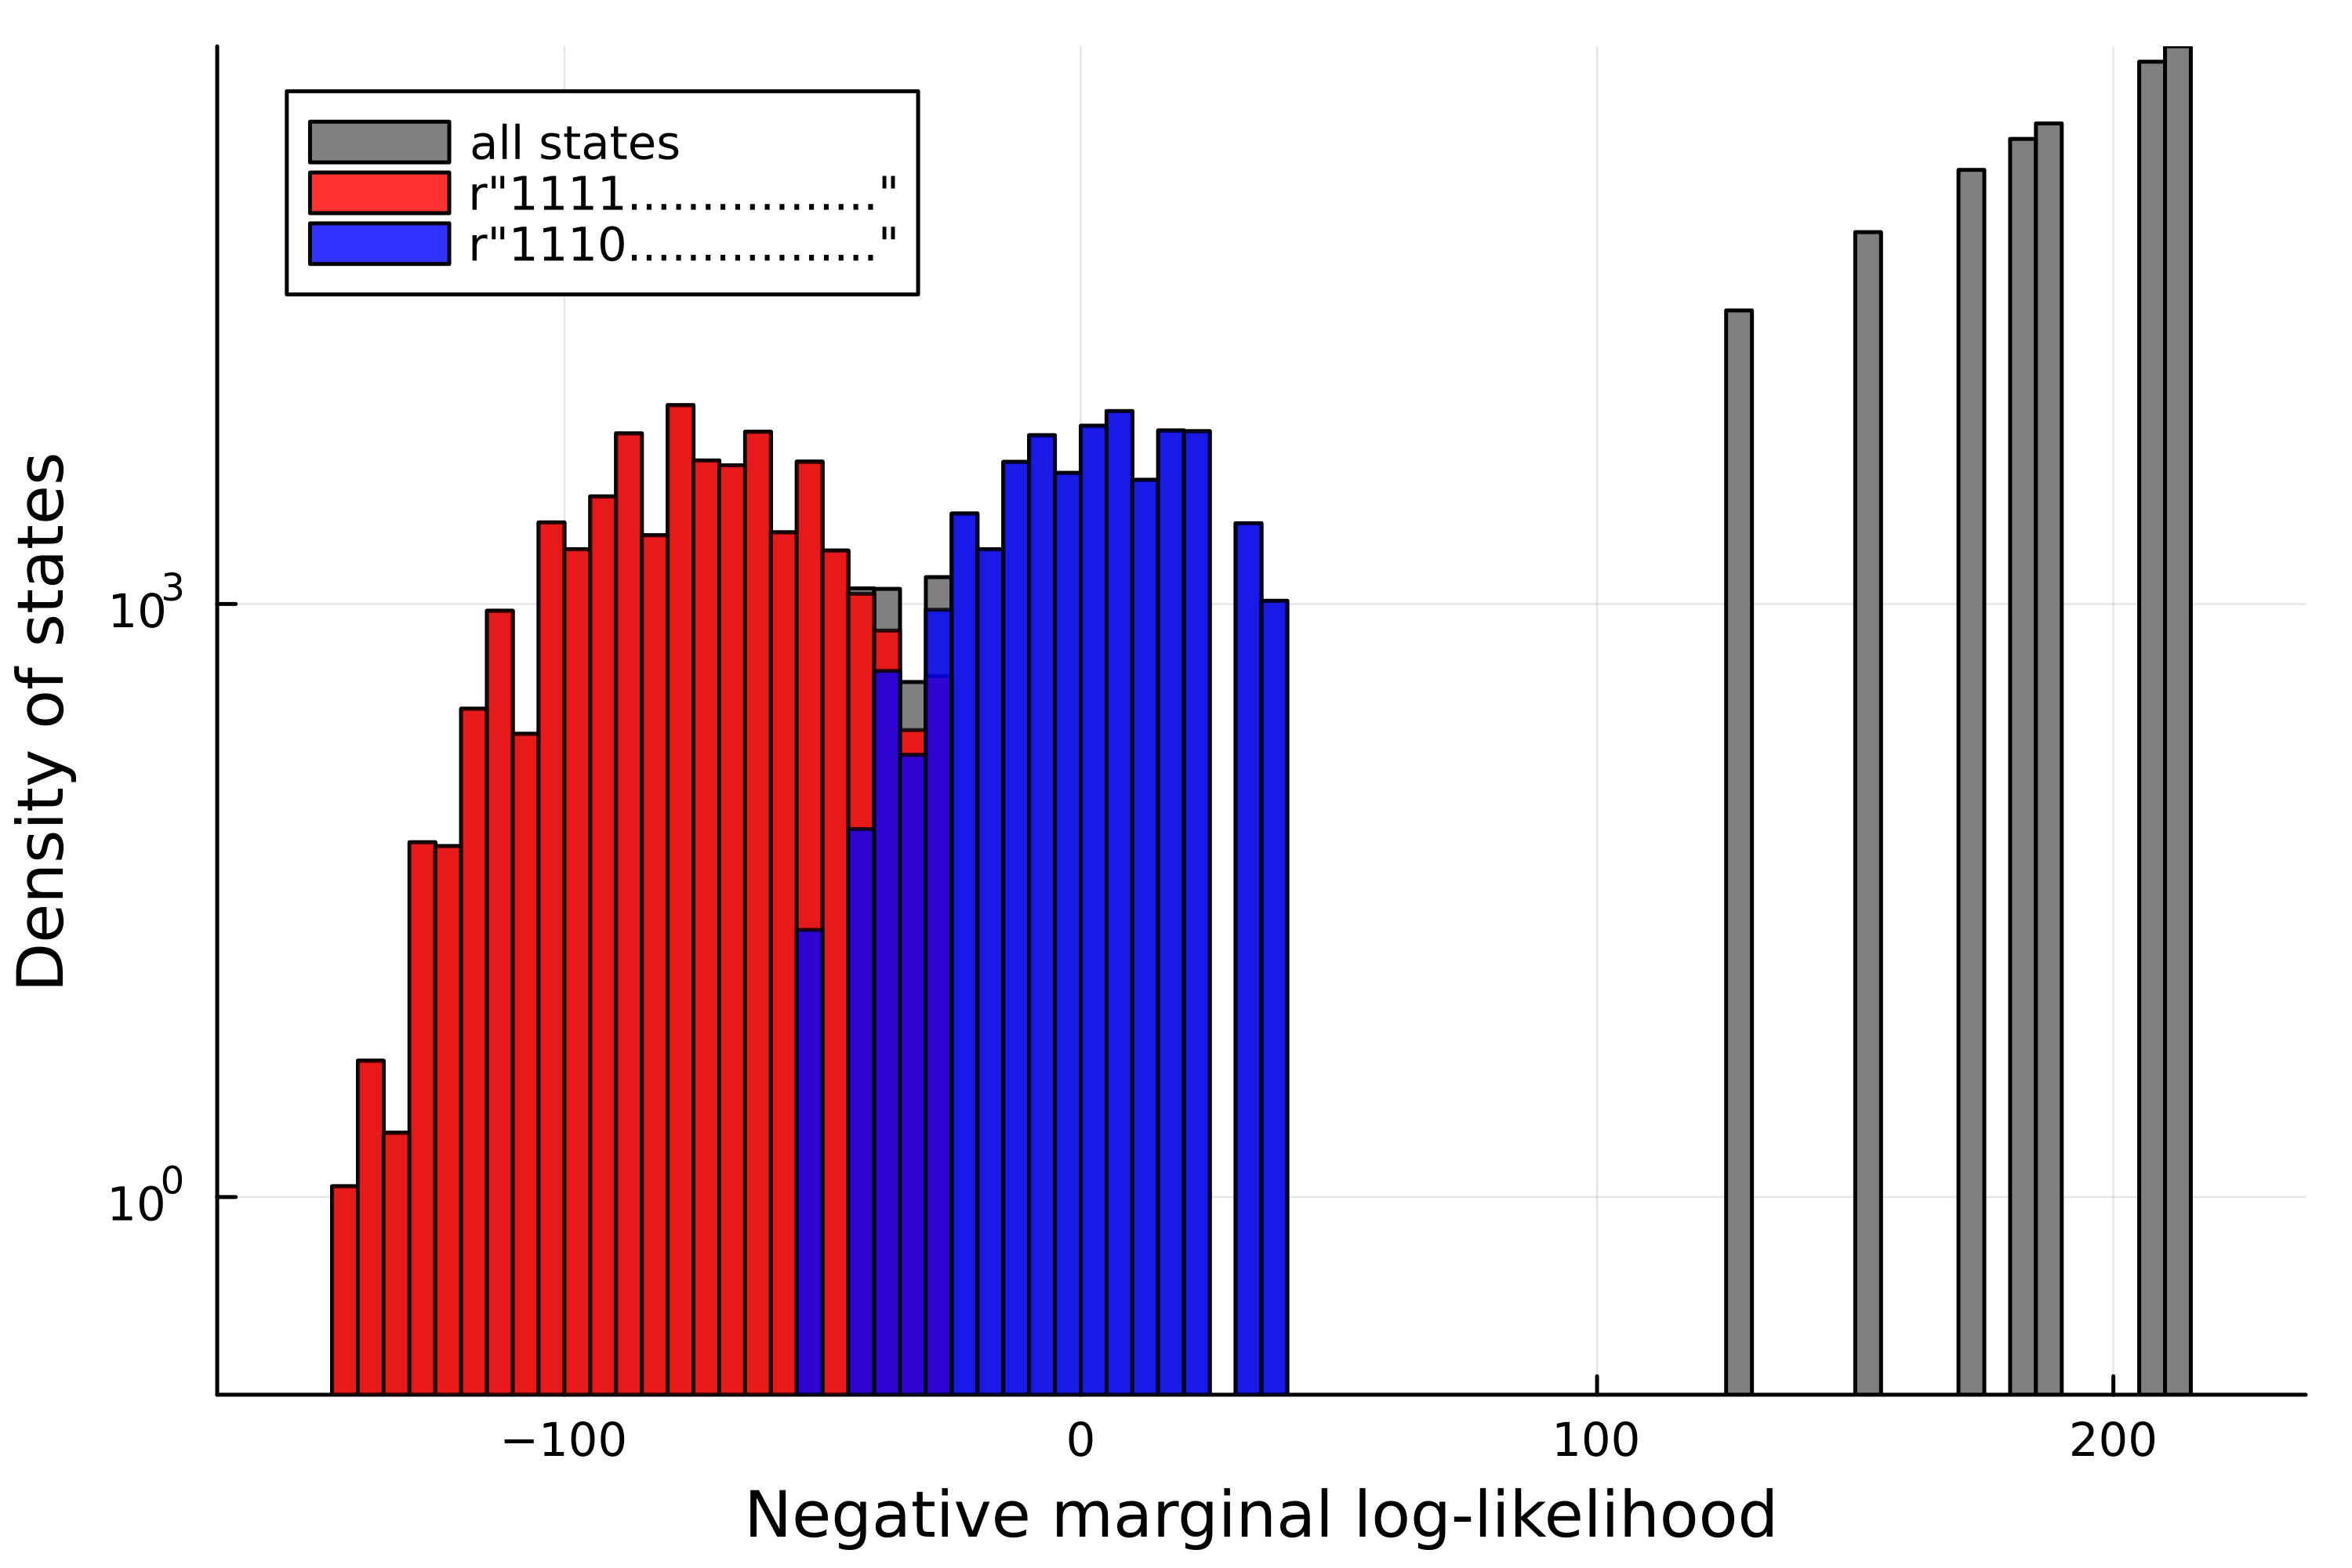

In [290]:
bottom = 1e-1
### --------------------------------------------------------------------------------------------------------
plt = bar( E[D.!=0],  num_states .*( D[D.!=0] / sum(D[D.!=0]) ), legend=false,
xlabel="Negative marginal log-likelihood", ylabel = "Density of states",yscale=:log10, 
dpi=500, color="gray",  bar_width=width, label="all states", fillrange=bottom)



### --------------------------------------------------------------------------------------------------------
p_i = r"1111................."
c_i = "red"
df_selected = df[occursin.(p_i, df.P), :]
histₛ = fit(Histogram, vec(Float64.(df_selected.E)), hist.edges[1])
Eₛ = (Vector(histₛ.edges[1])[1:end-1] + Vector(histₛ.edges[1])[2:end]) ./ 2.0
Hₛ = histₛ.weights
Dₛ = vec( Hₛ ./ ( exp.( - Eₛ*B' ) * ( n ./ Z ) ) )
plt = bar!( Eₛ[Dₛ.!=0], num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ), legend=true,
                    xlabel="Negative marginal log-likelihood", ylabel = "Density of states", 
                    yscale=:log10,dpi=500, color=c_i, bar_width=width,
                    label=p_i, alpha=0.8, fillrange=bottom)



### --------------------------------------------------------------------------------------------------------
p_i = r"1110................."
c_i = "blue"
df_selected = df[occursin.(p_i, df.P), :]
histₛ = fit(Histogram, vec(Float64.(df_selected.E)), hist.edges[1])
Eₛ = (Vector(histₛ.edges[1])[1:end-1] + Vector(histₛ.edges[1])[2:end]) ./ 2.0
Hₛ = histₛ.weights
Dₛ = vec( Hₛ ./ ( exp.( - Eₛ*B' ) * ( n ./ Z ) ) )
plt = bar!( Eₛ[Dₛ.!=0], num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ), legend=true,
                    xlabel="Negative marginal log-likelihood", ylabel = "Density of states",
                    yscale=:log10, dpi=500, color=c_i, bar_width=width,
                    label=p_i, alpha=0.8, fillrange=bottom)



### --------------------------------------------------------------------------------------------------------
# p_i = "K<3"
# c_i = "green"
# df_selected = df[df.K.==5, :]
# histₛ = fit(Histogram, vec(Float64.(df_selected.E)), hist.edges[1])
# Eₛ = (Vector(histₛ.edges[1])[1:end-1] + Vector(histₛ.edges[1])[2:end]) ./ 2.0
# Hₛ = histₛ.weights
# Dₛ = vec( Hₛ ./ ( exp.( - Eₛ*B' ) * ( n ./ Z ) ) )
# plt = bar!( Eₛ[Dₛ.!=0], num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ), legend=true,
#                     xlabel="Negative marginal log-likelihood", ylabel = "Density of states",
#                     yscale=:log10, dpi=500, color=c_i, bar_width=width,
#                     label=p_i, alpha=0.8, fillrange=bottom)

In [285]:
num_states .*( D / sum(D) )

72-element Vector{Float64}:
      1.133695286485426
      4.8914382869906445
      2.11341184979468
     62.31316417752432
     59.59135933584964
    295.1688416885526
    923.6734738307205
    220.3508060789047
   2584.916014646908
   1891.477470656702
      ⋮
 156996.7127462702
      0.0
 225260.4022672813
 269742.1280682126
      0.0
      0.0
      0.0
 553618.7900709739
 662363.0281352187